# Methods and Imports

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import datetime as dt
import decimal

time_utilization_graph = []
idle_power_watt = 0.212
max_power_watt = 0.597
xLabelCount = 13

def power_estimation(percentage):
    scaling_power = max_power_watt - idle_power_watt
    return idle_power_watt + scaling_power * percentage

def analyse_load_graph(file_to_analyze):
    time_utilization_graph.clear()
    load = []
    with open(file_to_analyze, 'r') as load_csv_file:
        debug_index = 0
        year = csv.reader(load_csv_file, delimiter=',')
        for hour in year:
            debug_index = debug_index + 1
            time_utilization_graph.append(hour[0][:-3])
            load.append(float(hour[8]))
    return load

def analyse_power_consumption(cpu_utilization):
    power_consumption_of_cluster = []
    for cluster_utilization_measured in cpu_utilization:
        power_consumption_of_cluster.append(power_estimation(cluster_utilization_measured / 100))
    return power_consumption_of_cluster

def get_daily_min(input: np.array):
    arr = input.copy()
    result = []
    for i in range(0,24):
        min = 0
        for j in range(1,24):
            if arr[j] < arr[min]:
                min = j
        arr[min] = 9999
        result.append(min)
    return result

# Parameters and Constants

In [2]:
FOLDER = "benchmark_3"
START_HOUR = 17

# benchmark_1 : 17
# benchmark_3 : 17

# Get data

In [3]:
optimized_df = pd.read_csv(FOLDER+'/optimized.csv', names=['TimeStamp','CPUMili','CPUPercent','CpuPercentPrecise','cpuMiliReservation','cpuPercentReservation','cpuPreciseReservation', 'SLA'])
optimized_df.index = optimized_df['TimeStamp']
optimized_df = optimized_df.drop(columns=['TimeStamp'])

unoptimized_df = pd.read_csv('benchmark_9/unoptimized.csv', names=['TimeStamp','CPUMili','CPUPercent','CpuPercentPrecise','cpuMiliReservation','cpuPercentReservation','cpuPreciseReservation','CPUMili2','CPUPercent2','CpuPercentPrecise2','cpuMiliReservation2','cpuPercentReservation2','cpuPreciseReservation2', 'SLA'])
unoptimized_df.index = unoptimized_df['TimeStamp']
unoptimized_df = unoptimized_df.drop(columns=['TimeStamp'])

optimized = analyse_load_graph(FOLDER+'/optimized.csv')
unoptimized = analyse_load_graph(FOLDER+'/unoptimized.csv')
co2_prediction_data = np.genfromtxt(FOLDER+'/co2_prediction.csv')
real_co2_emission_data = np.genfromtxt(FOLDER+'/co2_emission.csv')

i = 0
for v in unoptimized_df['SLA']:
    if v > 0:
        v-=1
    unoptimized_df['SLA'][i] = v
    i+=1
i = 0
for v in optimized_df['SLA']:
    if v > 0:
        v-=1
    optimized_df['SLA'][i] = v
    i+=1


c:\Users\moria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\moria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Calcualte potential savings

In [4]:
co2_rank = get_daily_min(real_co2_emission_data)
workload = np.genfromtxt(FOLDER+'/workload_actual.csv')
static = 750/4000
critical_workload = []
non_critical_workload = []
limit = 1
for w in workload: 
    critical_workload.append((w - static) * 0.6 + static)
    non_critical_workload.append((w - static) * 0.4)

optimal_workload = critical_workload.copy()
for i in range(0,24):
    t = (START_HOUR + i) % 24
    if t == 16:
        print()
    w = non_critical_workload[t]
    j = 0
    while w > 0:
        if j > 23:
            optimal_workload[t] = limit
            break
        if ((co2_rank[j] < t) and (t < START_HOUR)) or ((t < START_HOUR) and (START_HOUR < co2_rank[j])) or ((START_HOUR < co2_rank[j]) and (co2_rank[j] < t)):
            j += 1
            continue
        if optimal_workload[co2_rank[j]] + w <= limit:
            optimal_workload[co2_rank[j]] = optimal_workload[co2_rank[j]] + w
            w = 0
        else:
            optimal_workload[co2_rank[j]] = limit
            w = w - limit + optimal_workload[co2_rank[j]]
        j += 1

power_consumption = []
predicted_optimal_power_consumption = []
for i in range(0,24):
    t = (START_HOUR + i) % 24
    power_consumption.append(power_estimation(optimal_workload[t]))
    for k in range(0,60):
        predicted_optimal_power_consumption.append(power_estimation(optimal_workload[t]))

co2_sum = 0
co2_accumulated = []
co2_per_hour = []
for index in range(0, len(power_consumption)):
    index = (index + START_HOUR) % 24
    current_co2 = power_consumption[index]* real_co2_emission_data[index]
    co2_sum += current_co2
    for k in range(0,60):
        co2_accumulated.append(co2_sum)
        co2_per_hour.append(current_co2)

In [5]:
print("error ", abs(1-sum(optimal_workload)/sum(workload)))

error  0.00022017652884942507


# Plot CPU Reservation

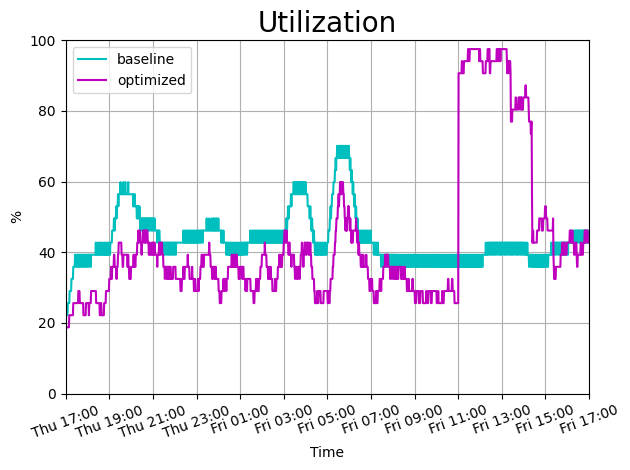

In [6]:
predicted_optimal = []
for i in range(0,len(workload)):
    t = (i + START_HOUR) % 24
    for j in range(0,60):
        predicted_optimal.append(optimal_workload[t]*100)

x_tics = []
x_labels = []

for date in range(0, xLabelCount):
    x_tics.append(date * 120)
    x_labels.append(time_utilization_graph[date * 120])

axes = plt

plt.plot(time_utilization_graph[:-1], unoptimized[:-1], color='c', linestyle='solid', label="baseline")
plt.plot(time_utilization_graph[:-1], optimized[:-1], color='m', linestyle='solid', label="optimized")
plt.xticks(rotation=20)
plt.xticks(x_tics, x_labels)

plt.xlabel('Time')
plt.ylabel('%')
plt.title('Utilization', fontsize=20)

plt.grid()
plt.ylim([0, 100])
plt.xlim([0, len(time_utilization_graph) - 1])
plt.legend()
plt.tight_layout()
file_title = "cluster_cpu_reservation_" + FOLDER
plt.get_current_fig_manager().set_window_title(file_title)
plt.savefig(file_title + ".pdf", bbox_inches="tight")

# Plot Power Model

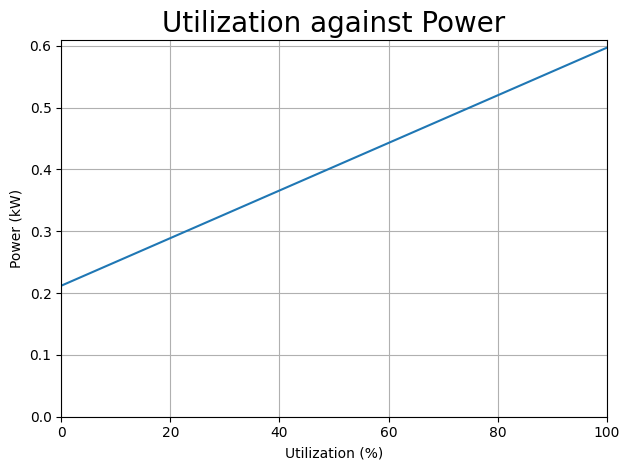

In [7]:
utilization_list = []
power_consumption_list = []
for i in range(0, 11):
    utilization = i * 0.1
    utilization_list.append(utilization * 100)
    power_consumption_list.append(power_estimation(utilization))

plt.clf()
plt.ylim(0, max(power_consumption_list) * 1.02)
plt.xlim(0, max(utilization_list))
plt.title('Utilization against Power', fontsize=20)
plt.xlabel('Utilization (%)')
plt.ylabel('Power (kW)')

plt.grid()

plt.plot(utilization_list, power_consumption_list)
plt.tight_layout()
file_title = "power_model"
plt.get_current_fig_manager().set_window_title(file_title)
plt.savefig(file_title + ".pdf")

# Calculate Graph for Power Consumption

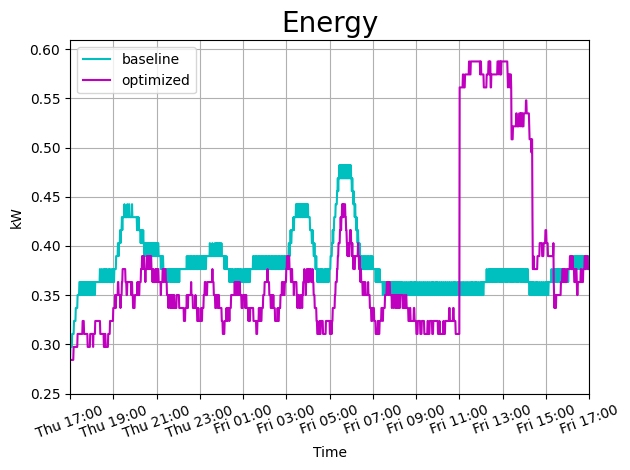

In [8]:
power_consumption_of_unoptimized_cluster = analyse_power_consumption(unoptimized)
power_consumption_of_optimized_cluster = analyse_power_consumption(optimized)

plt.plot(time_utilization_graph[:-1], power_consumption_of_unoptimized_cluster[:-1], color='c', linestyle='solid',label="baseline")
plt.plot(time_utilization_graph[:-1], power_consumption_of_optimized_cluster[:-1], color='m', linestyle='solid', label="optimized")

plt.xticks(x_tics, x_labels)
plt.xticks(rotation=20)
plt.ylim(0.25, max_power_watt * 1.02)
plt.xlim([0, len(time_utilization_graph) - 1])
plt.xlabel('Time')
plt.ylabel('kW')
plt.title('Energy', fontsize=20)
plt.legend()
plt.grid()
plt.tight_layout()
file_title = "cluster_power_consumption_" + FOLDER
plt.get_current_fig_manager().set_window_title(file_title)
plt.savefig(file_title + ".pdf", bbox_inches="tight")

# CO2 Efficiency Graph

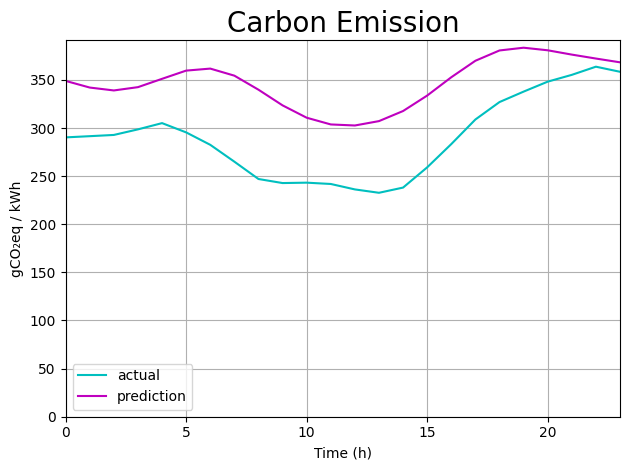

In [9]:
co2_emission_time = range(0,24)

plt.plot(co2_emission_time, real_co2_emission_data, color='c', linestyle='solid', label="actual")
plt.plot(co2_emission_time, co2_prediction_data, color='m', linestyle='solid', label="prediction")
plt.title('Carbon Emission', fontsize=20)
plt.grid()
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('gCO₂eq / kWh')

plt.ylim(0, max(max(real_co2_emission_data), max(co2_prediction_data)) * 1.02)
plt.xlim(0, max(co2_emission_time))
plt.tight_layout()
file_title = "co2_prediction_accuracy_" + FOLDER
plt.get_current_fig_manager().set_window_title(file_title)
plt.savefig(file_title + ".pdf", bbox_inches="tight")

# Calculate Total Emissions

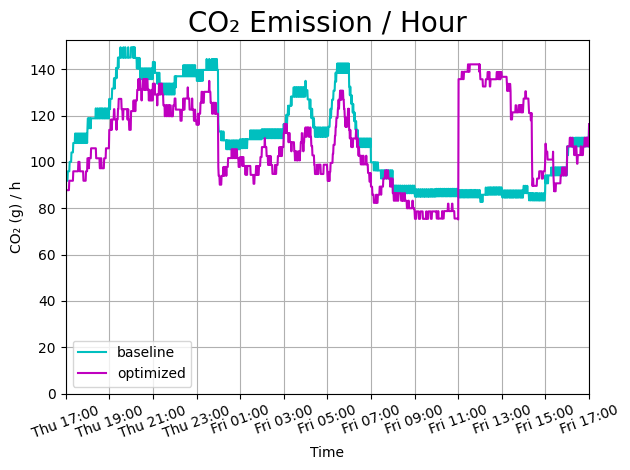

In [10]:
co2_unoptimized_sum = 0.0
co2_unoptimized_accumulated = []
co2_per_hour_unoptimized = []

co2_optimized_sum = 0.0
co2_optimized_accumulated = []
co2_per_hour_optimized = []

co2_per_hour_versus = []

co2_predicted_sum = 0
co2_predicted_accumulated = []
co2_per_hour_predicted = []
co2_per_hour_versus_predicted = []

for index in range(0, len(power_consumption_of_unoptimized_cluster)):
    co2_hour_index = (int(index / 60) + START_HOUR) % 24  # create for lookup
    current_co2 = power_consumption[int(index / 60)% 24]* real_co2_emission_data[co2_hour_index]
    co2_predicted_sum += (current_co2 / 60) 
    co2_predicted_accumulated.append(co2_predicted_sum)
    co2_per_hour_predicted.append(current_co2)

    current_co2_unoptimized = power_consumption_of_unoptimized_cluster[index]* real_co2_emission_data[co2_hour_index]
    co2_unoptimized_sum = co2_unoptimized_sum + (current_co2_unoptimized / 60)
    co2_unoptimized_accumulated.append(co2_unoptimized_sum)
    co2_per_hour_unoptimized.append(current_co2_unoptimized)

    current_co2_optimized = power_consumption_of_optimized_cluster[index]* real_co2_emission_data[
        co2_hour_index]
    co2_optimized_sum = co2_optimized_sum + (current_co2_optimized / 60)
    co2_optimized_accumulated.append(co2_optimized_sum)
    co2_per_hour_optimized.append(current_co2_optimized)

    co2_per_hour_versus.append(co2_unoptimized_sum - co2_optimized_sum)
    co2_per_hour_versus_predicted.append(co2_unoptimized_sum - co2_predicted_sum)

plt.plot(time_utilization_graph, co2_per_hour_unoptimized, color='c', linestyle='solid',
         label="baseline")
plt.plot(time_utilization_graph, co2_per_hour_optimized, color='m', linestyle='solid', label="optimized")
plt.title('CO₂ Emission / Hour', fontsize=20)
plt.grid()
plt.legend()
plt.xticks(rotation=20)
plt.xticks(x_tics, x_labels)
plt.xlabel('Time')
plt.ylabel('CO₂ (g) / h')
plt.ylim(0, max(max(co2_per_hour_unoptimized), max(co2_per_hour_optimized)) * 1.02)
plt.xlim([0, len(time_utilization_graph) - 1])
plt.tight_layout()
file_title = "co2_emissions_per_hour_" + FOLDER
plt.get_current_fig_manager().set_window_title(file_title)
plt.savefig(file_title + ".pdf", bbox_inches="tight")
plt.show()

In [11]:
print("Total emissions ", co2_unoptimized_sum)
print("Total savings in percent: ",(1 - co2_optimized_sum/co2_unoptimized_sum) * 100)

Total emissions  2645.979606883868
Total savings in percent:  2.2987348435569044


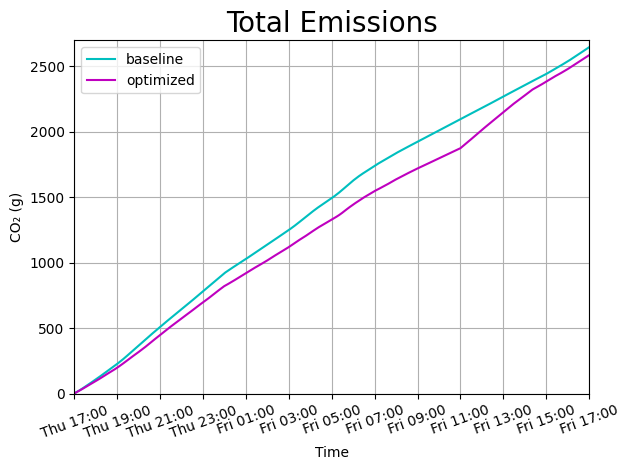

In [12]:
plt.plot(time_utilization_graph, co2_unoptimized_accumulated, color='c', linestyle='solid', label="baseline")
plt.plot(time_utilization_graph, co2_optimized_accumulated, color='m', linestyle='solid',
         label="optimized")
plt.title('Total Emissions', fontsize=20)
plt.grid()
plt.legend()
plt.xticks(rotation=20)
plt.xticks(x_tics, x_labels)
plt.xlabel('Time')
plt.ylabel('CO₂ (g)')
plt.ylim(0, max(co2_unoptimized_sum, co2_optimized_sum) * 1.02)
plt.xlim([0, len(time_utilization_graph) - 1])
plt.tight_layout()
file_title = "co2_emissions_accumulated_" + FOLDER
plt.get_current_fig_manager().set_window_title(file_title)
plt.savefig(file_title + ".pdf", bbox_inches="tight")
plt.show()

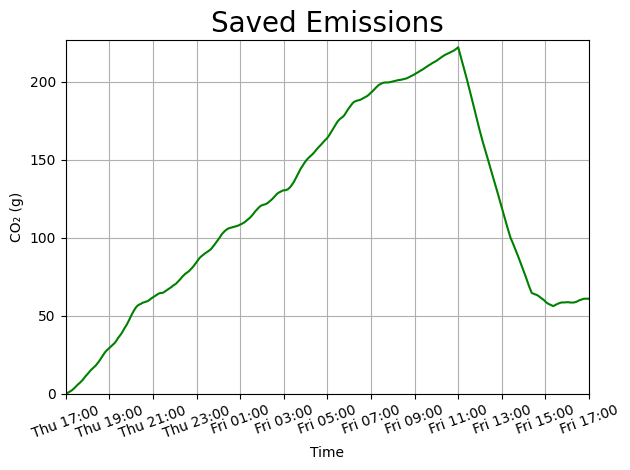

In [13]:
plt.plot(time_utilization_graph, co2_per_hour_versus, color='g', linestyle='solid')
plt.title('Saved Emissions', fontsize=20)
plt.grid()
plt.xticks(rotation=20)
plt.xticks(x_tics, x_labels)
plt.xlabel('Time')
plt.ylabel('CO₂ (g)')
plt.ylim(min(co2_per_hour_versus), max(co2_per_hour_versus) * 1.02)
plt.xlim([0, len(time_utilization_graph) - 1])
plt.tight_layout()
file_title = "accumulated_co2_emissions_per_hour_difference" + FOLDER
plt.get_current_fig_manager().set_window_title(file_title)
plt.savefig(file_title + ".pdf", bbox_inches="tight")

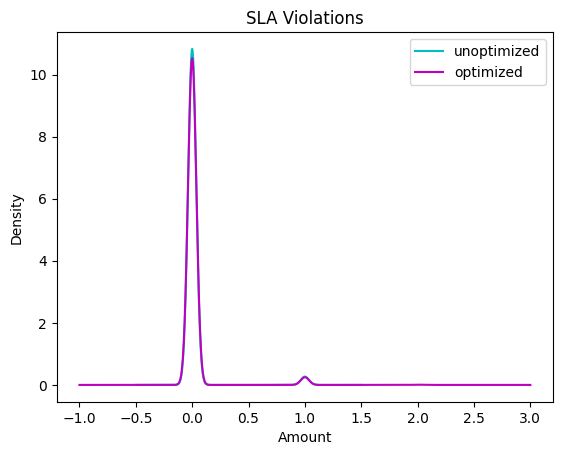

In [14]:
unoptimized_df['SLA'].plot(label='unoptimized', color='c', legend=True, kind='density')
optimized_df['SLA'].plot(label='optimized', color='m', legend=True, kind='density')
plt.title("SLA Violations")
plt.xlabel("Amount")
plt.savefig("Violations_"+FOLDER+".pdf", bbox_inches="tight")